Este notebook está pensado para ser ejecutado en Google Colab

In [ ]:
#!pip install gdown
#!pip install helical==0.0.1a23

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of gtfparse to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of gtfparse to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to

In [2]:
from helical.utils import get_anndata_from_hf_dataset
from helical import GeneformerConfig, GeneformerFineTuningModel, scGPTConfig, scGPTFineTuningModel
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import logging, warnings
import umap
import pandas as pd
import seaborn as sns
import scanpy as sc
import os
import gdown
import anndata as ad
from datasets import load_dataset

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:datasets:PyTorch version 2.5.1+cu124 available.
INFO:datasets:Polars version 1.21.0 available.
INFO:datasets:TensorFlow version 2.18.0 available.
INFO:datasets:JAX version 0.4.33 available.
INFO:helical:Caduceus not available: If you want to use this model, ensure you have a CUDA GPU and have installed the optional helical[mamba-ssm] dependencies.


## Datos Helical

In [ ]:
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, download_mode="reuse_cache_if_exists")

train_dataset = get_anndata_from_hf_dataset(ds["train"])
test_dataset = get_anndata_from_hf_dataset(ds["test"])

# Nivel 1 de clasificación
cell_types_train_1 = list(np.array(train_dataset.obs["LVL1"].tolist()))
cell_types_test_1 = list(np.array(test_dataset.obs["LVL1"].tolist()))

label_set_1 = set(cell_types_train_1) | set(cell_types_test_1) # Unimos ambos conjuntos
class_id_dict_1 = dict(zip(label_set_1, [i for i in range(len(label_set_1))]))
id_class_dict_1 = {v: k for k, v in class_id_dict_1.items()}


#Sustituimos los enteros por sus identificadores numéricos
for i in range(len(cell_types_train_1)):
    cell_types_train_1[i] = class_id_dict_1[cell_types_train_1[i]]

for i in range(len(cell_types_test_1)):
    cell_types_test_1[i] = class_id_dict_1[cell_types_test_1[i]]

y_true_test_1 = test_dataset.obs["LVL1"].astype('category').cat.codes.to_numpy()

# Nivel 2 de clasificación
cell_types_train_2 = list(np.array(train_dataset.obs["LVL2"].tolist()))
cell_types_test_2 = list(np.array(test_dataset.obs["LVL2"].tolist()))

label_set_2 = set(cell_types_train_2) | set(cell_types_test_2)
class_id_dict_2 = dict(zip(label_set_2, [i for i in range(len(label_set_2))]))
id_class_dict_2 = {v: k for k, v in class_id_dict_2.items()}


for i in range(len(cell_types_train_2)):
    cell_types_train_2[i] = class_id_dict_2[cell_types_train_2[i]]

for i in range(len(cell_types_test_1)):
    cell_types_test_2[i] = class_id_dict_2[cell_types_test_2[i]]

y_true_test_2 = test_dataset.obs["LVL2"].astype('category').cat.codes.to_numpy()

# Nivel 3 de clasificación
cell_types_train_3 = list(np.array(train_dataset.obs["LVL3"].tolist()))
cell_types_test_3 = list(np.array(test_dataset.obs["LVL3"].tolist()))

label_set_3 = set(cell_types_train_3) | set(cell_types_test_3)
class_id_dict_3 = dict(zip(label_set_3, [i for i in range(len(label_set_3))]))
id_class_dict_3 = {v: k for k, v in class_id_dict_3.items()}

for i in range(len(cell_types_train_3)):
    cell_types_train_3[i] = class_id_dict_3[cell_types_train_3[i]]

for i in range(len(cell_types_test_3)):
    cell_types_test_3[i] = class_id_dict_3[cell_types_test_3[i]]

y_true_test_3 = test_dataset.obs["LVL3"].astype('category').cat.codes.to_numpy()

# Reducimos dimensionalidad
sc.pp.highly_variable_genes(train_dataset, n_top_genes=3000, flavor='seurat_v3', inplace=True)
train_dataset = train_dataset[:, train_dataset.var["highly_variable"]]

sc.pp.highly_variable_genes(test_dataset, n_top_genes=3000, flavor='seurat_v3', inplace=True)
test_dataset = test_dataset[:, test_dataset.var["highly_variable"]]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Datos Esclerosis Múltiple

In [3]:
output_dir = "../data/ms"
if os.path.exists(output_dir):

    print("data already downloaded!!")

else:

    folder_id = "1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v"
    gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", output=output_dir, quiet=False)

Retrieving folder contents


Processing file 1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl .DS_Store
Processing file 1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi c_data.h5ad
Processing file 1casFhq4InuBNhJLMnGebzkRXM2UTTeQG filtered_ms_adata.h5ad


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl
To: /data/ms/.DS_Store
100%|██████████| 6.15k/6.15k [00:00<00:00, 14.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi
To: /data/ms/c_data.h5ad
100%|██████████| 20.6M/20.6M [00:00<00:00, 76.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1casFhq4InuBNhJLMnGebzkRXM2UTTeQG
To: /data/ms/filtered_ms_adata.h5ad
100%|██████████| 47.1M/47.1M [00:00<00:00, 66.4MB/s]
Download completed


In [4]:
data_train = ad.read_h5ad(f'../data/ms/c_data.h5ad')
data_test = ad.read_h5ad(f'../data/ms/filtered_ms_adata.h5ad')

data_test.var = data_test.var.set_index('gene_name')
data_test.var["gene_name"] = data_test.var.index

cell_types_train = list(np.array(data_train.obs["celltype"].tolist()))
cell_types_test = list(np.array(data_test.obs["celltype"].tolist()))

label_set = set(cell_types_train) | set(cell_types_test) # Unimos ambos conjuntos
class_id_dict = dict(zip(label_set, [i for i in range(len(label_set))]))
id_class_dict = {v: k for k, v in class_id_dict.items()}


#Sustituimos los enteros por sus identificadores numéricos
for i in range(len(cell_types_train)):
    cell_types_train[i] = class_id_dict[cell_types_train[i]]

for i in range(len(cell_types_test)):
    cell_types_test[i] = class_id_dict[cell_types_test[i]]

# Modelo Geneformer

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Versión pre-entrenada sobre 95-M células, 12 capas

## Aplicado a datos Helical

**Nivel 1**

In [ ]:
geneformer_config = GeneformerConfig(device=device, batch_size=16, model_name="gf-12L-95M-i4096") # Último modelo, 12 capas
geneformer_fine_tune_1 = GeneformerFineTuningModel(geneformer_config=geneformer_config, fine_tuning_head="classification", output_size=len(label_set_1))

geneformerh_train_dataset = geneformer_fine_tune_1.process_data(train_dataset)
geneformerh_test_dataset = geneformer_fine_tune_1.process_data(test_dataset)

geneformerh_train_dataset = geneformerh_train_dataset.add_column("LVL1", cell_types_train_1)
geneformerh_test_dataset = geneformerh_test_dataset.add_column("LVL1", cell_types_test_1)

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/geneformer/v2
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v2/gene_median_dictionary.pkl'
Downloading: 100%|██████████| 1.51M/1.51M [00:01<00:00, 1.37MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v2/gene_median_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v2/token_dictionary.pkl'
Downloading: 100%|██████████| 426k/426k [00:00<00:00, 2.35MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v2/token_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/

Map:   0%|          | 0/25344 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 2791 genes to Ensembl IDs from a total of 3000 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 6336 × 3000
    obs: 'LVL1', 'LVL2', 'LVL3', 'total_counts'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'index', 'ensembl_id'
    uns: 'hvg' has no column attribute 'filter_pass'; 

Map:   0%|          | 0/6336 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.


In [ ]:
geneformer_fine_tune_1.train(train_dataset=geneformerh_train_dataset.shuffle(), validation_dataset=geneformerh_test_dataset, label="LVL1", freeze_layers=0, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

INFO:helical.models.geneformer.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|██████████| 396/396 [02:43<00:00,  2.43it/s, val_loss=0.0998]
INFO:helical.models.geneformer.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


In [ ]:
outputs_geneformerh_train = geneformer_fine_tune_1.get_outputs(geneformerh_train_dataset)
outputs_geneformerh_test = geneformer_fine_tune_1.get_outputs(geneformerh_test_dataset)

embeddings_geneformerh_train = geneformer_fine_tune_1.get_embeddings(geneformerh_train_dataset)
embeddings_geneformerh_test_1 = geneformer_fine_tune_1.get_embeddings(geneformerh_test_dataset)

y_pred_test_h_1 = outputs_geneformerh_test.argmax(axis=1)

print("---- Resultados Train Datos Helical------")
print(classification_report(cell_types_train_1,outputs_geneformerh_train.argmax(axis=1)))

print("---- Resultados Test Datos Helical------")
print(classification_report(cell_types_test_1,outputs_geneformerh_test.argmax(axis=1)))

Generating Outputs: 100%|██████████| 396/396 [02:41<00:00,  2.45it/s]
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/1584 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/396 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


---- Resultados Train Datos Helical------
              precision    recall  f1-score   support

           0       1.00      0.34      0.51        53
           1       1.00      1.00      1.00      7053
           2       0.99      0.98      0.99      6129
           3       0.95      0.98      0.96       167
           4       0.99      1.00      0.99     11766
           5       0.79      0.87      0.83       176

    accuracy                           0.99     25344
   macro avg       0.95      0.86      0.88     25344
weighted avg       0.99      0.99      0.99     25344

---- Resultados Test Datos Helical------
              precision    recall  f1-score   support

           0       1.00      0.21      0.35        19
           1       1.00      0.95      0.97      2321
           2       0.96      0.98      0.97       938
           3       0.92      0.95      0.94        38
           4       0.97      1.00      0.98      3001
           5       0.41      0.58      0.48      

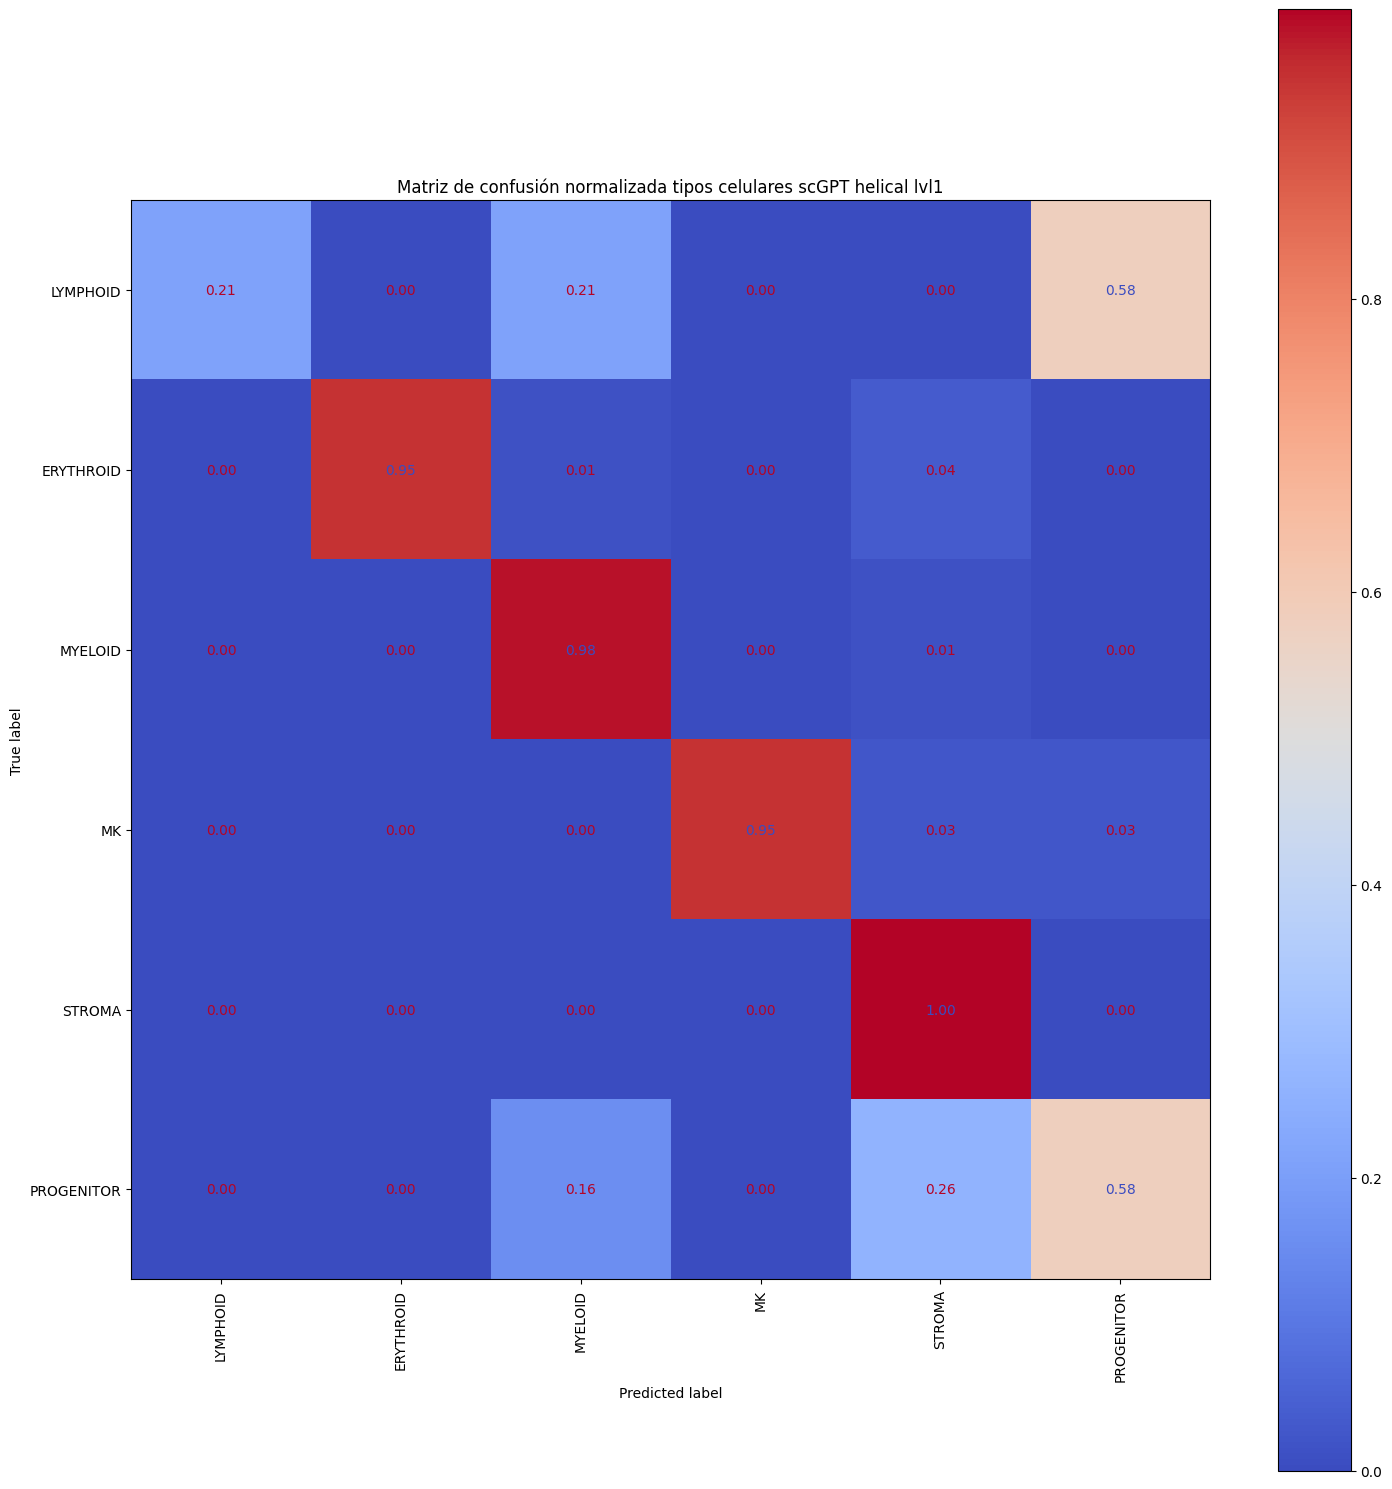

In [ ]:
cm = confusion_matrix(cell_types_test_1, outputs_geneformerh_test.argmax(axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

unique_labels = np.unique(np.concatenate((cell_types_test_1, outputs_geneformerh_test.argmax(axis=1))))

class_names = [id_class_dict_1[label] for label in unique_labels]

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

ax.set_title('Matriz de confusión normalizada tipos celulares scGPT helical lvl1')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

**Nivel 2**

In [ ]:
geneformer_config = GeneformerConfig(device=device, batch_size=16, model_name="gf-12L-95M-i4096") # Último modelo, 12 capas
geneformer_fine_tune_2 = GeneformerFineTuningModel(geneformer_config=geneformer_config, fine_tuning_head="classification", output_size=len(label_set_2))

geneformerh_train_dataset = geneformer_fine_tune_2.process_data(train_dataset)
geneformerh_test_dataset = geneformer_fine_tune_2.process_data(test_dataset)

geneformerh_train_dataset = geneformerh_train_dataset.add_column("LVL2", cell_types_train_2)
geneformerh_test_dataset = geneformerh_test_dataset.add_column("LVL2", cell_types_test_2)

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/geneformer/v2
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v2/gene_median_dictionary.pkl'
Downloading: 100%|██████████| 1.51M/1.51M [00:02<00:00, 674kB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v2/gene_median_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v2/token_dictionary.pkl'
Downloading: 100%|██████████| 426k/426k [00:00<00:00, 2.11MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v2/token_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/d

Map:   0%|          | 0/25344 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 2789 genes to Ensembl IDs from a total of 3000 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 6336 × 3000
    obs: 'LVL1', 'LVL2', 'LVL3', 'total_counts'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'index', 'ensembl_id'
    uns: 'hvg' has no column attribute 'filter_pass'; 

Map:   0%|          | 0/6336 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.


29 minutos

In [ ]:
geneformer_fine_tune_2.train(train_dataset=geneformerh_train_dataset.shuffle(), validation_dataset=geneformerh_test_dataset, label="LVL2", freeze_layers=0, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

INFO:helical.models.geneformer.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|██████████| 396/396 [02:38<00:00,  2.49it/s, val_loss=0.55]
INFO:helical.models.geneformer.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


In [ ]:
outputs_geneformerh_train = geneformer_fine_tune_2.get_outputs(geneformerh_train_dataset)
outputs_geneformerh_test = geneformer_fine_tune_2.get_outputs(geneformerh_test_dataset)

embeddings_geneformerh_train = geneformer_fine_tune_2.get_embeddings(geneformerh_train_dataset)
embeddings_geneformerh_test_2 = geneformer_fine_tune_2.get_embeddings(geneformerh_test_dataset)

y_pred_test_h_2 = outputs_geneformerh_test.argmax(axis=1)

print("---- Resultados Train Datos Helical------")
print(classification_report(cell_types_train_2,outputs_geneformerh_train.argmax(axis=1)))

print("---- Resultados Test Datos Helical------")
print(classification_report(cell_types_test_2,outputs_geneformerh_test.argmax(axis=1)))

Generating Outputs: 100%|██████████| 396/396 [02:37<00:00,  2.52it/s]
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/1584 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/396 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


---- Resultados Train Datos Helical------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1152
           1       0.98      0.98      0.98      6016
           2       0.88      0.62      0.73       681
           3       0.00      0.00      0.00        16
           4       0.92      0.94      0.93      5625
           5       1.00      0.92      0.96       167
           6       0.83      0.45      0.59        11
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00        16
           9       0.70      0.72      0.71        46
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00         7
          12       0.48      0.96      0.64        49
          13       0.86      0.60      0.71        10
          14       0.82      0.75      0.78        24
          15       0.00      0.00      0.00         1
          16       0.90      0.96      

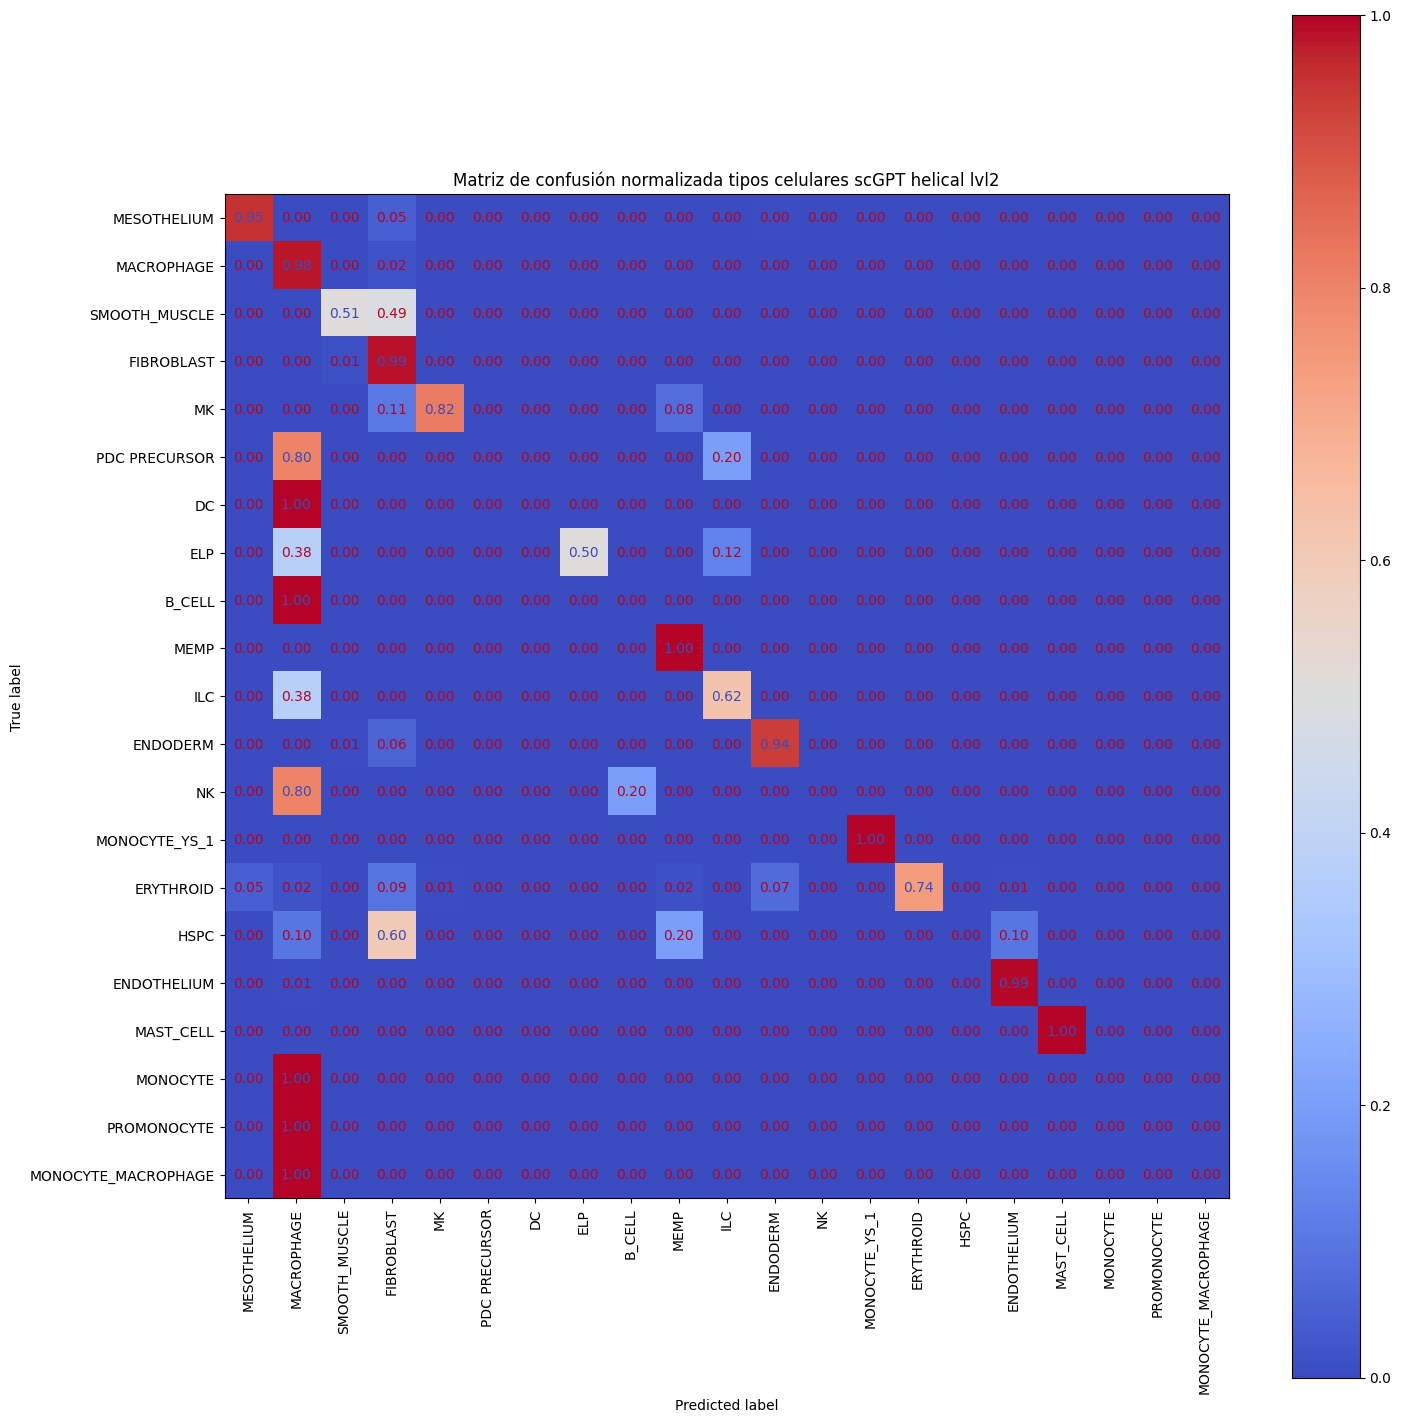

In [ ]:
cm = confusion_matrix(cell_types_test_2, outputs_geneformerh_test.argmax(axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

unique_labels = np.unique(np.concatenate((cell_types_test_2, outputs_geneformerh_test.argmax(axis=1))))

class_names = [id_class_dict_2[label] for label in unique_labels]

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

ax.set_title('Matriz de confusión normalizada tipos celulares scGPT helical lvl2')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

**Nivel 3**

In [ ]:
geneformer_config = GeneformerConfig(device=device, batch_size=16, model_name="gf-12L-95M-i4096") # Último modelo, 12 capas
geneformer_fine_tune_3 = GeneformerFineTuningModel(geneformer_config=geneformer_config, fine_tuning_head="classification", output_size=len(label_set_3))

geneformerh_train_dataset = geneformer_fine_tune_3.process_data(train_dataset)
geneformerh_test_dataset = geneformer_fine_tune_3.process_data(test_dataset)

geneformerh_train_dataset = geneformerh_train_dataset.add_column("LVL3", cell_types_train_3)
geneformerh_test_dataset = geneformerh_test_dataset.add_column("LVL3", cell_types_test_3)

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/geneformer/v2
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v2/gene_median_dictionary.pkl'
Downloading: 100%|██████████| 1.51M/1.51M [00:01<00:00, 1.45MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v2/gene_median_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v2/token_dictionary.pkl'
Downloading: 100%|██████████| 426k/426k [00:00<00:00, 4.19MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v2/token_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/

Map:   0%|          | 0/25344 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 2791 genes to Ensembl IDs from a total of 3000 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 6336 × 3000
    obs: 'LVL1', 'LVL2', 'LVL3', 'total_counts'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'index', 'ensembl_id'
    uns: 'hvg' has no column attribute 'filter_pass'; 

Map:   0%|          | 0/6336 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.


In [ ]:
geneformer_fine_tune_3.train(train_dataset=geneformerh_train_dataset.shuffle(), validation_dataset=geneformerh_test_dataset, label="LVL3", freeze_layers=0, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

INFO:helical.models.geneformer.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|██████████| 396/396 [02:45<00:00,  2.40it/s, val_loss=0.459]
INFO:helical.models.geneformer.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


In [ ]:
outputs_geneformerh_train = geneformer_fine_tune_3.get_outputs(geneformerh_train_dataset)
outputs_geneformerh_test = geneformer_fine_tune_3.get_outputs(geneformerh_test_dataset)

embeddings_geneformerh_train = geneformer_fine_tune_3.get_embeddings(geneformerh_train_dataset)
embeddings_geneformerh_test_3 = geneformer_fine_tune_3.get_embeddings(geneformerh_test_dataset)

y_pred_test_h_3 = outputs_geneformerh_test.argmax(axis=1)

print("---- Resultados Train Datos Helical------")
print(classification_report(cell_types_train_3,outputs_geneformerh_train.argmax(axis=1)))

print("---- Resultados Test Datos Helical------")
print(classification_report(cell_types_test_3,outputs_geneformerh_test.argmax(axis=1)))

Generating Outputs: 100%|██████████| 396/396 [02:43<00:00,  2.42it/s]
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/1584 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/396 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


---- Resultados Train Datos Helical------
              precision    recall  f1-score   support

           0       0.57      0.33      0.42        12
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.89      0.46      0.61       345
           5       0.80      1.00      0.89        47
           6       0.99      0.95      0.97       167
           7       0.76      0.78      0.77        49
           8       0.61      0.95      0.74      3466
           9       0.82      0.32      0.46        44
          10       0.36      0.40      0.38        10
          11       0.00      0.00      0.00         2
          12       0.55      0.07      0.13       937
          13       1.00      0.96      0.98      1152
          14       0.89      0.97      0.93      5625
          15       0.00      0.00      0.00         2
          16       0.00      0.00      

In [ ]:
cm = confusion_matrix(cell_types_test_3, outputs_geneformerh_test.argmax(axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

unique_labels = np.unique(np.concatenate((cell_types_test_3, outputs_geneformerh_test.argmax(axis=1))))

class_names = [id_class_dict_3[label] for label in unique_labels]

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

ax.set_title('Matriz de confusión normalizada tipos celulares scGPT helical lvl3')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

## Aplicado a Esclerosis Múltiple

In [6]:
geneformer_config = GeneformerConfig(device=device, batch_size=16, model_name="gf-12L-95M-i4096") # Último modelo, 12 capas
geneformer_fine_tune = GeneformerFineTuningModel(geneformer_config=geneformer_config, fine_tuning_head="classification", output_size=len(label_set))

geneformerm_train_dataset = geneformer_fine_tune.process_data(data_train, use_raw_counts=False)
geneformerm_test_dataset = geneformer_fine_tune.process_data(data_test, use_raw_counts=False)

geneformerm_train_dataset = geneformerm_train_dataset.add_column("TIPOS", cell_types_train)
geneformerm_test_dataset = geneformerm_test_dataset.add_column("TIPOS", cell_types_test)

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/geneformer/v2
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v2/gene_median_dictionary.pkl'
Downloading: 100%|██████████| 1.51M/1.51M [00:01<00:00, 1.44MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v2/gene_median_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v2/token_dictionary.pkl'
Downloading: 100%|██████████| 426k/426k [00:00<00:00, 4.11MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v2/token_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/

Map:   0%|          | 0/7844 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 2733 genes to Ensembl IDs from a total of 3000 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 13468 × 3000
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Character

Map:   0%|          | 0/13468 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.


In [7]:
geneformer_fine_tune.train(train_dataset=geneformerm_train_dataset.shuffle(), validation_dataset=geneformerm_test_dataset, label="TIPOS", freeze_layers=0, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

INFO:helical.models.geneformer.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|██████████| 842/842 [04:27<00:00,  3.15it/s, val_loss=0.582]
INFO:helical.models.geneformer.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


In [8]:
outputs_geneformerm_train = geneformer_fine_tune.get_outputs(geneformerm_train_dataset)
outputs_geneformerm_test = geneformer_fine_tune.get_outputs(geneformerm_test_dataset)

embeddings_geneformerm_train = geneformer_fine_tune.get_embeddings(geneformerm_train_dataset)
embeddings_geneformerm_test = geneformer_fine_tune.get_embeddings(geneformerm_test_dataset)

y_pred = outputs_geneformerm_test.argmax(axis=1)

Generating Outputs: 100%|██████████| 842/842 [04:24<00:00,  3.18it/s]
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/491 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/842 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


In [9]:
print("---- Resultados Train Esclerosis------")
print(classification_report(cell_types_train,outputs_geneformerm_train.argmax(axis=1)))

print("---- Resultados Test Esclerosis------")
print(classification_report(cell_types_test,outputs_geneformerm_test.argmax(axis=1)))

---- Resultados Train Esclerosis------
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1019
           1       0.00      0.00      0.00         3
           2       0.89      0.78      0.83       997
           3       0.84      0.96      0.90      2010
           4       0.90      0.96      0.93       569
           5       0.86      0.89      0.87       234
           6       0.86      0.74      0.79       172
           7       0.90      1.00      0.95        38
           8       0.95      0.98      0.96        53
           9       0.97      0.94      0.95       662
          10       1.00      0.25      0.40         4
          11       0.85      0.87      0.86        60
          12       0.98      0.89      0.93        55
          13       0.91      0.83      0.87      1284
          14       0.96      0.99      0.97       154
          15       1.00      0.07      0.13       114
          16       0.00      0.00      0.0

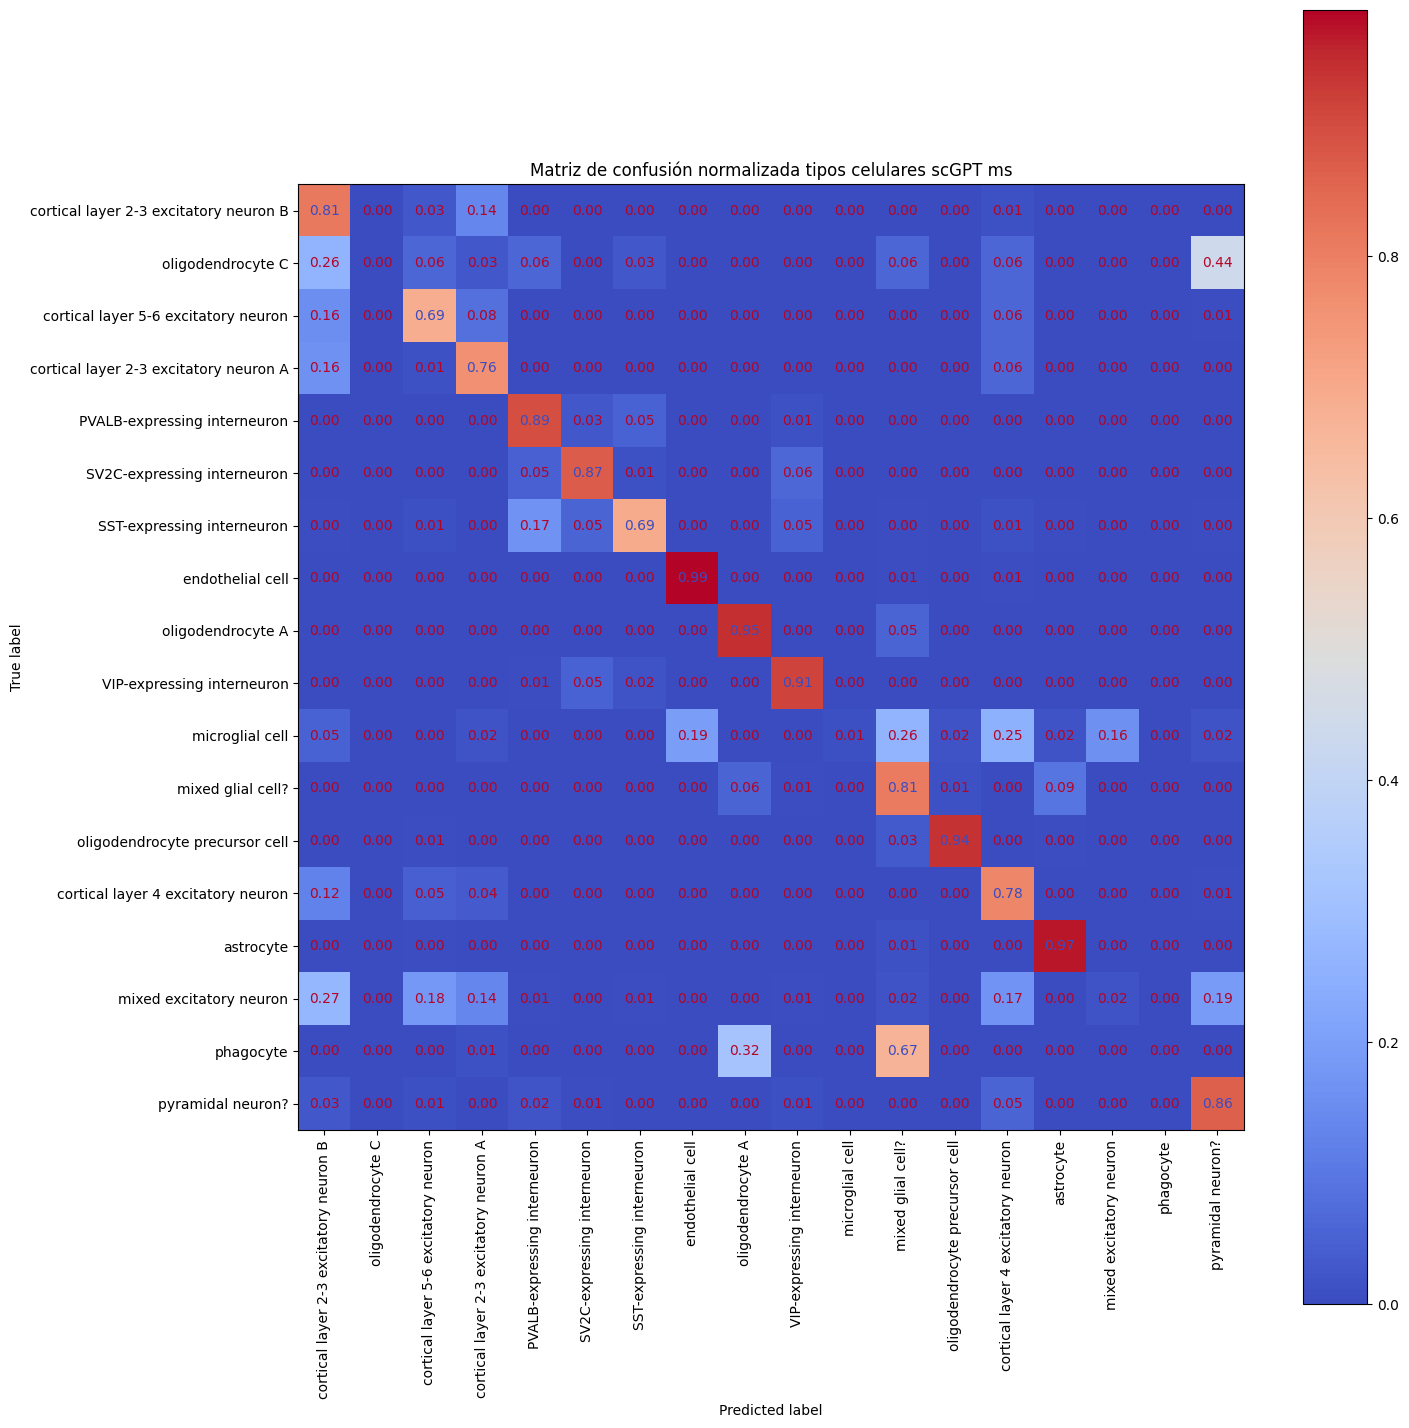

In [10]:
cm = confusion_matrix(cell_types_test, outputs_geneformerm_test.argmax(axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

unique_labels = np.unique(np.concatenate((cell_types_test, outputs_geneformerm_test.argmax(axis=1))))

class_names = [id_class_dict[label] for label in unique_labels]

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

ax.set_title('Matriz de confusión normalizada tipos celulares scGPT ms')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

# Visualización de Embeddings Geneformer fine-tuned

## Datos Esclerosis Múltiple

In [11]:
embeddings_test = ad.AnnData(X=embeddings_geneformerm_test)
data_test.obsm["X_scgpt"] = embeddings_test.X

sc.tl.pca(embeddings_test)
data_test.obsm["X_pca"] = embeddings_test.obsm['X_pca']
data_test.uns["pca"] = embeddings_test.uns['pca']

sc.pp.neighbors(embeddings_test, use_rep="X")
sc.tl.umap(embeddings_test, random_state = 0)


data_test.obsm["X_umap"] = embeddings_test.obsm["X_umap"]
data_test.uns["neighbors"] = embeddings_test.uns['neighbors']
data_test.obsp["distances"] = embeddings_test.obsp['distances']
data_test.obsp["connectivities"] = embeddings_test.obsp['connectivities']
data_test.obs["Preds"] = y_pred

sc.tl.tsne(data_test, use_rep = "X_pca", random_state = 0)

Podemos representar los embeddings coloreando por columnas específicas o simplemente obtener la representación general, comparando t-SNE y UMAP.

In [ ]:
sc.pl.umap(data_test, color=["Preds"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell types(ms)")

In [ ]:
sc.pl.umap(data_test, color=["celltype"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell types(ms)")

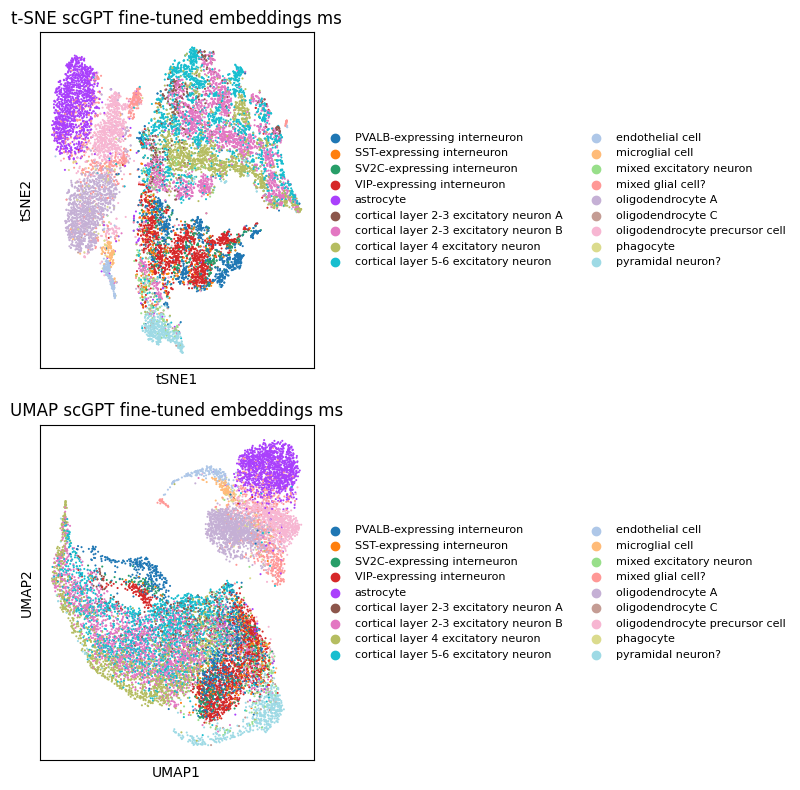

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sc.pl.tsne(data_test, color='celltype', ax=ax1, show=False, title='t-SNE scGPT fine-tuned embeddings ms', legend_fontsize=8)
sc.pl.umap(data_test, color='celltype', ax=ax2, show=False, title='UMAP scGPT fine-tuned embeddings ms', legend_fontsize=8)

plt.tight_layout()
plt.show()

## Datos Helical

**Nivel 1**

In [ ]:
embeddings_test = ad.AnnData(X=embeddings_geneformerh_test_1)
test_dataset.obsm["X_scgpt"] = embeddings_test.X

sc.tl.pca(embeddings_test)
test_dataset.obsm["X_pca"] = embeddings_test.obsm['X_pca']
test_dataset.uns["pca"] = embeddings_test.uns['pca']

sc.pp.neighbors(embeddings_test, use_rep="X")
sc.tl.umap(embeddings_test, random_state = 0)


test_dataset.obsm["X_umap"] = embeddings_test.obsm["X_umap"]
test_dataset.uns["neighbors"] = embeddings_test.uns['neighbors']
test_dataset.obsp["distances"] = embeddings_test.obsp['distances']
test_dataset.obsp["connectivities"] = embeddings_test.obsp['connectivities']
test_dataset.obs["Preds"] = y_pred_test_h_1

sc.tl.tsne(test_dataset, use_rep = "X_pca", random_state = 0)

... storing 'LVL1' as categorical
... storing 'LVL2' as categorical
... storing 'LVL3' as categorical
... storing 'ensembl_id' as categorical


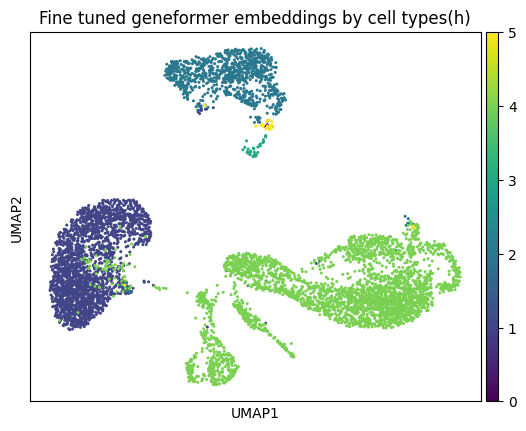

In [ ]:
sc.pl.umap(test_dataset, color=["Preds"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell types(h)")

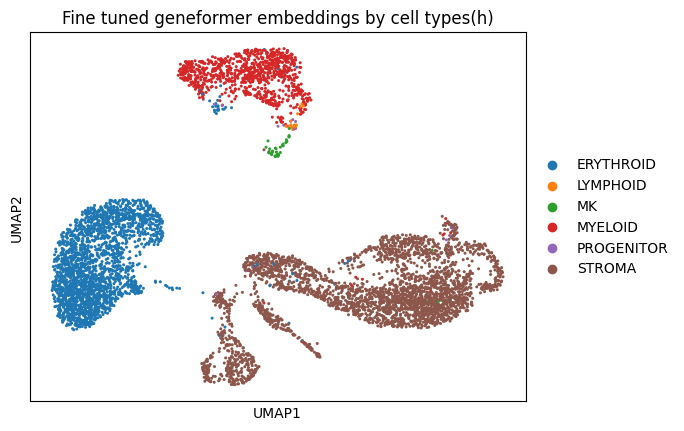

In [ ]:
sc.pl.umap(test_dataset, color=["LVL1"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell types(h)")

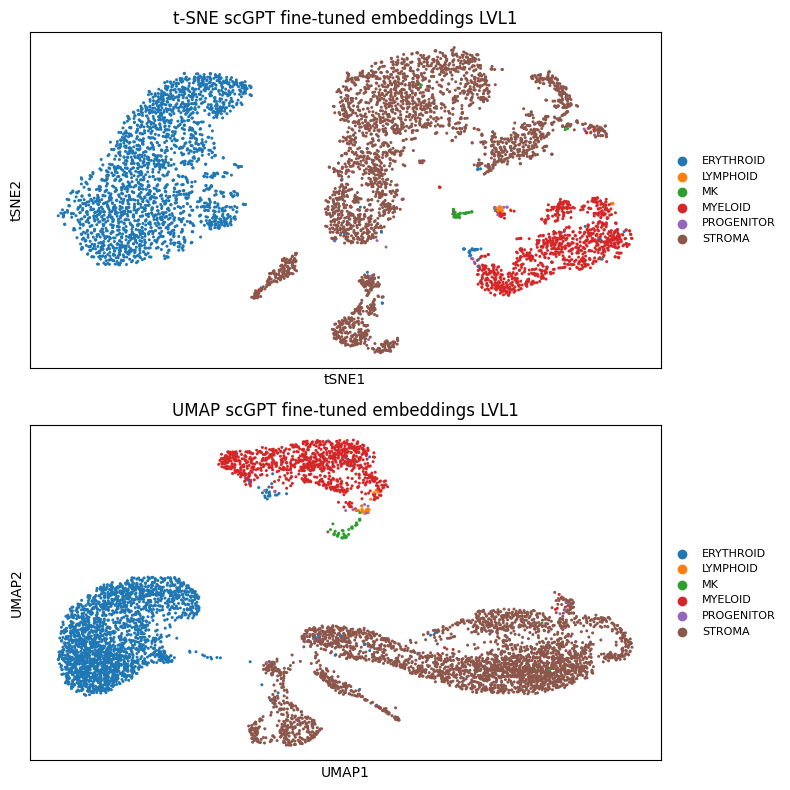

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sc.pl.tsne(test_dataset, color='LVL1', ax=ax1, show=False, title='t-SNE scGPT fine-tuned embeddings LVL1', legend_fontsize=8)
sc.pl.umap(test_dataset, color='LVL1', ax=ax2, show=False, title='UMAP scGPT fine-tuned embeddings LVL1', legend_fontsize=8)

plt.tight_layout()
plt.show()

**Nivel 2**

In [ ]:
embeddings_test = ad.AnnData(X=embeddings_geneformerh_test_2)
test_dataset.obsm["X_scgpt"] = embeddings_test.X

sc.tl.pca(embeddings_test)
test_dataset.obsm["X_pca"] = embeddings_test.obsm['X_pca']
test_dataset.uns["pca"] = embeddings_test.uns['pca']

sc.pp.neighbors(embeddings_test, use_rep="X")
sc.tl.umap(embeddings_test, random_state = 0)


test_dataset.obsm["X_umap"] = embeddings_test.obsm["X_umap"]
test_dataset.uns["neighbors"] = embeddings_test.uns['neighbors']
test_dataset.obsp["distances"] = embeddings_test.obsp['distances']
test_dataset.obsp["connectivities"] = embeddings_test.obsp['connectivities']
test_dataset.obs["Preds"] = y_pred_test_h_2

sc.tl.tsne(test_dataset, use_rep = "X_pca", random_state = 0)

... storing 'LVL1' as categorical
... storing 'LVL2' as categorical
... storing 'LVL3' as categorical
... storing 'ensembl_id' as categorical


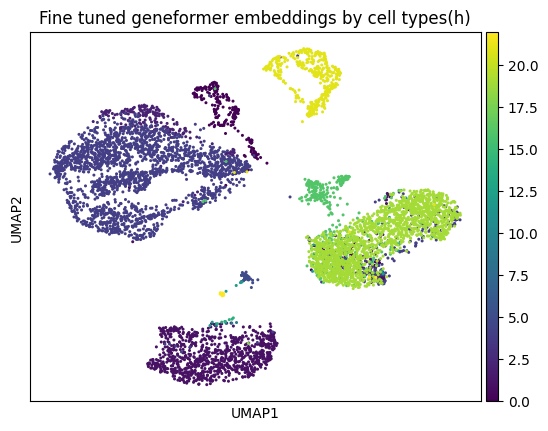

In [ ]:
sc.pl.umap(test_dataset, color=["Preds"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell types(h)")

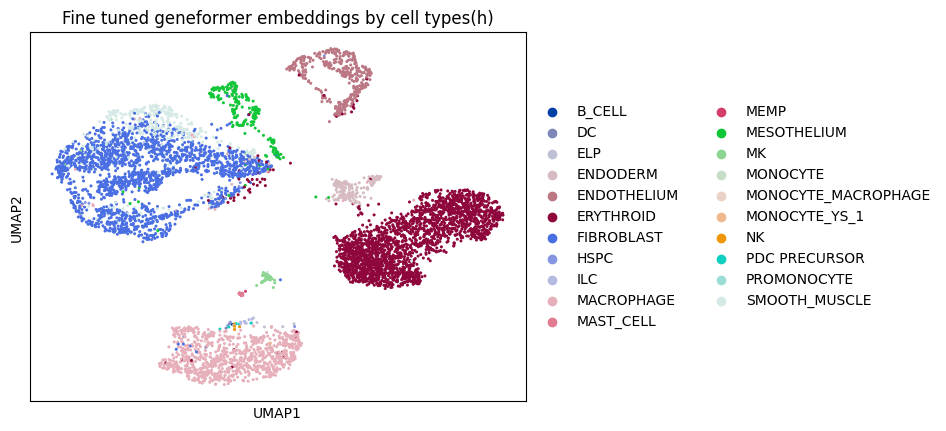

In [ ]:
sc.pl.umap(test_dataset, color=["LVL2"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell types(h)")

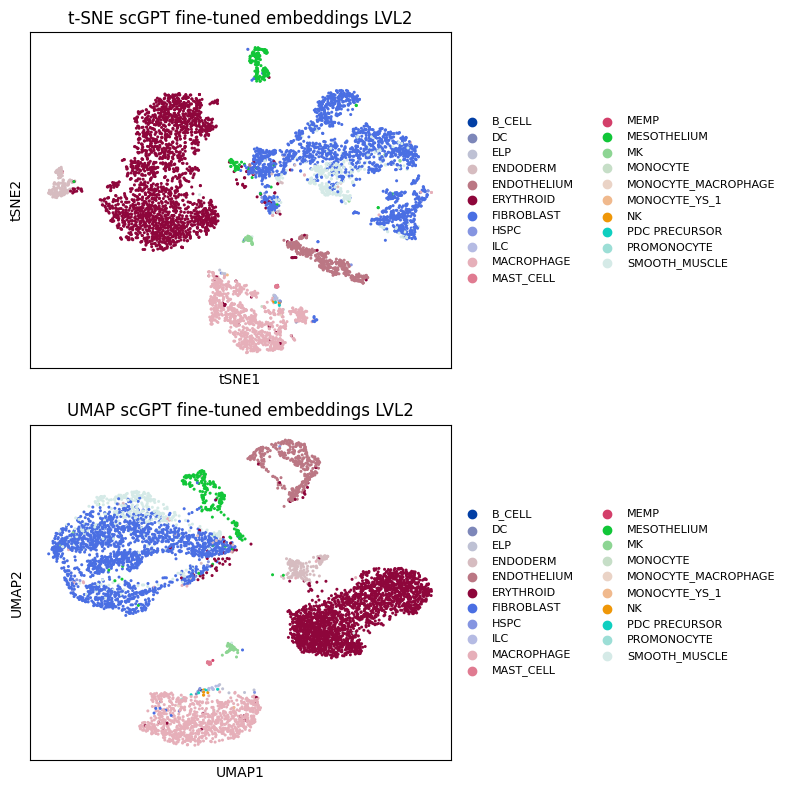

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sc.pl.tsne(test_dataset, color='LVL2', ax=ax1, show=False, title='t-SNE scGPT fine-tuned embeddings LVL2', legend_fontsize=8)
sc.pl.umap(test_dataset, color='LVL2', ax=ax2, show=False, title='UMAP scGPT fine-tuned embeddings LVL2', legend_fontsize=8)

plt.tight_layout()
plt.show()

**Nivel 3**

In [ ]:
embeddings_test = ad.AnnData(X=embeddings_geneformerh_test_3)
test_dataset.obsm["X_scgpt"] = embeddings_test.X

sc.tl.pca(embeddings_test)
test_dataset.obsm["X_pca"] = embeddings_test.obsm['X_pca']
test_dataset.uns["pca"] = embeddings_test.uns['pca']

sc.pp.neighbors(embeddings_test, use_rep="X")
sc.tl.umap(embeddings_test, random_state = 0)


test_dataset.obsm["X_umap"] = embeddings_test.obsm["X_umap"]
test_dataset.uns["neighbors"] = embeddings_test.uns['neighbors']
test_dataset.obsp["distances"] = embeddings_test.obsp['distances']
test_dataset.obsp["connectivities"] = embeddings_test.obsp['connectivities']
test_dataset.obs["Preds"] = y_pred_test_h_3

sc.tl.tsne(test_dataset, use_rep = "X_pca", random_state = 0)

... storing 'LVL1' as categorical
... storing 'LVL2' as categorical
... storing 'LVL3' as categorical
... storing 'ensembl_id' as categorical


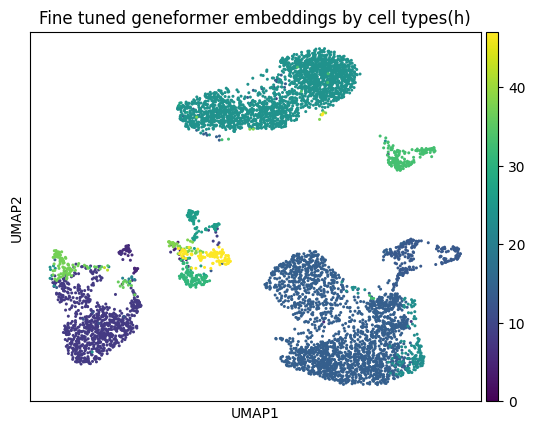

In [ ]:
sc.pl.umap(test_dataset, color=["Preds"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell types(h)")

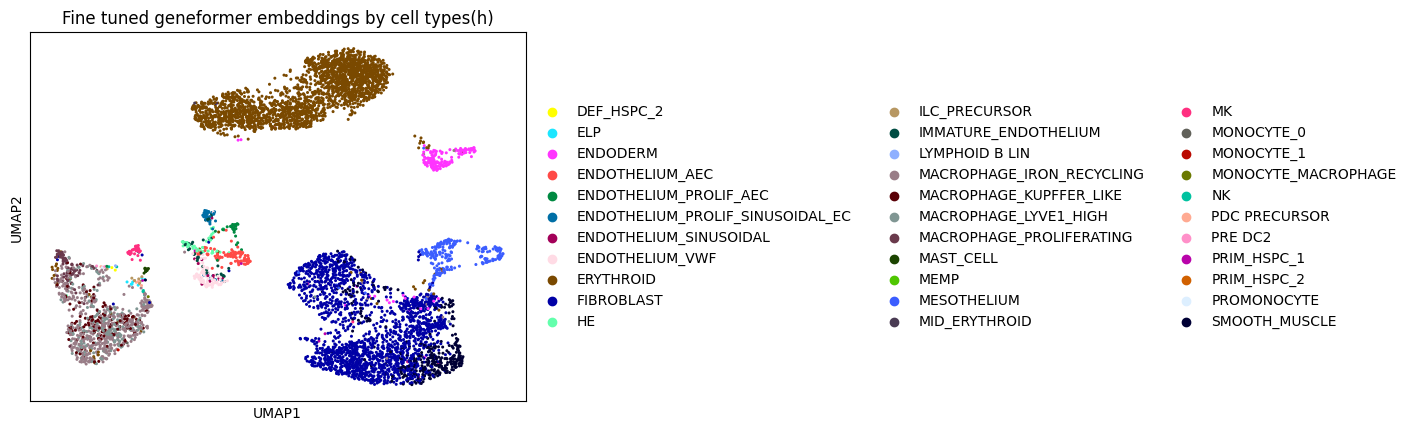

In [ ]:
sc.pl.umap(test_dataset, color=["LVL3"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell types(h)")

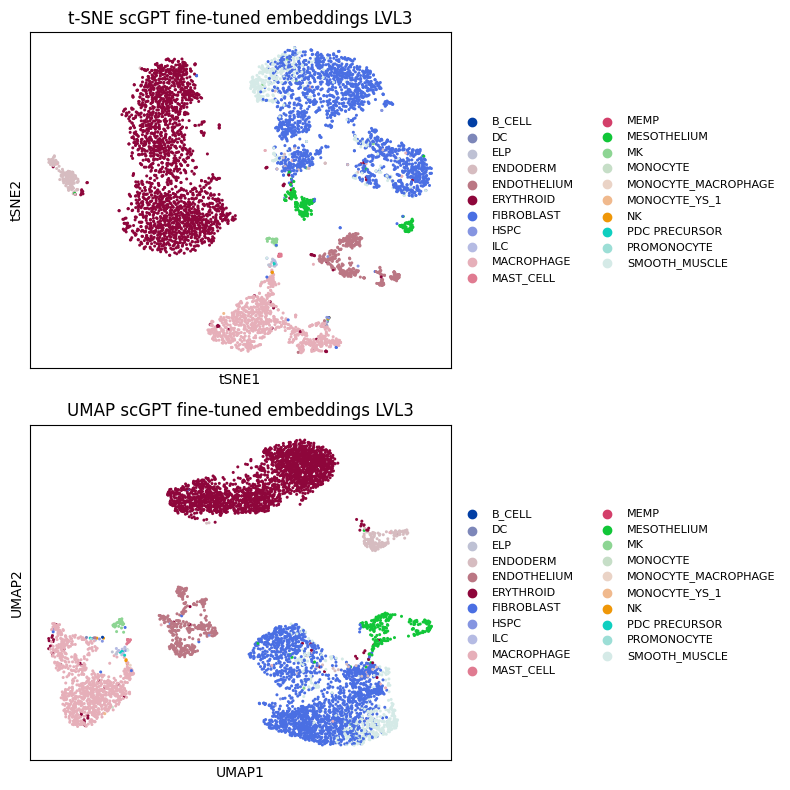

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sc.pl.tsne(test_dataset, color='LVL2', ax=ax1, show=False, title='t-SNE scGPT fine-tuned embeddings LVL3', legend_fontsize=8)
sc.pl.umap(test_dataset, color='LVL2', ax=ax2, show=False, title='UMAP scGPT fine-tuned embeddings LVL3', legend_fontsize=8)

plt.tight_layout()
plt.show()